Processing Alpine...
Processing Ararat...
Processing Ballarat...
Processing Banyule...
Processing Bass Coast...
Processing Baw Baw...
Processing Boroondara...
Processing Brimbank...
Processing Campaspe...
Processing Cardinia...
Processing Casey...
Processing Central Goldfields...
Processing Colac-Otway...
Processing Corangamite...
Processing Darebin...
Processing East Gippsland...
Processing Frankston...
Processing Gannawarra...
Processing Glen Eira...
Processing Greater Bendigo...
Processing Greater Dandenong...
Processing Greater Geelong...
Processing Greater Shepparton...
Processing Hepburn...
Processing Hindmarsh...
Processing Hobsons Bay...
Processing Horsham...
Processing Hume...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing Indigo...
Processing Knox...
Processing Macedon Ranges...
Processing Manningham...
Processing Maribyrnong...
Processing Maroondah...
Processing Melbourne...
Processing Melton...
Processing Mildura...
Processing Mitchell...
Processing Moira...
Processing Monash...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Moonee Valley...
Processing Moorabool...
Processing Mount Alexander...
Processing Moyne...
Processing Murrindindi...
Processing Northern Grampians...
Processing South Gippsland...
Processing Southern Grampians...
Processing Stonnington...
Processing Surf Coast...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Swan Hill...
Processing Towong...
Processing Wangaratta...
Processing Wellington...
Processing Whitehorse...
Processing Whittlesea...
Processing Wodonga...
Processing Wyndham...
Processing Yarra...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Yarra Ranges...
The regions with the highest projected growth over the next three years:
Wyndham       36.821040
Whittlesea    36.119851
Moira         33.711695
Hume          29.343023
Casey         26.548174
Glen Eira     25.939526
Swan Hill     25.339529
Melbourne     24.245395
Monash        22.879661
Whitehorse    22.690182
dtype: float64
Price increase forecast saved to ../data/results/price_increase_forecast_SARIMA.csv


/var/folders/kt/yhd0mp_91gn1qrk_l__r080r0000gn/T/ipykernel_26537/2852175773.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(top_regions))


Plot saved at ../plots/price_forecast_top10_SARIMA.png


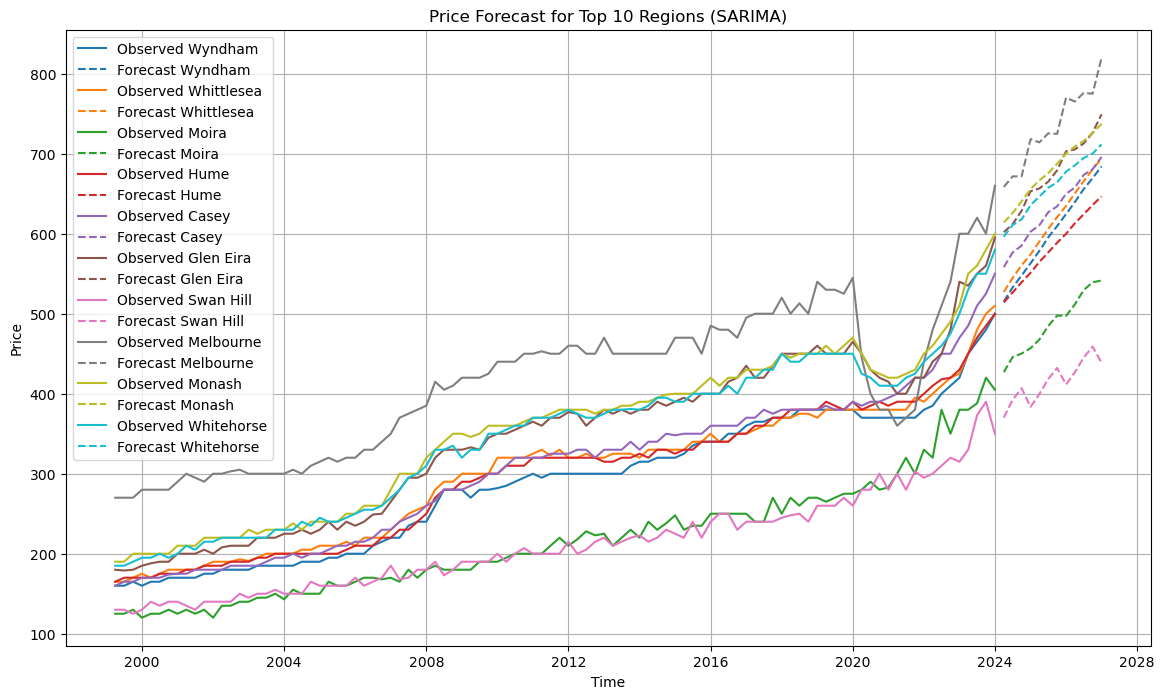

In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
import os
import sys
sys.path.append('..') 
from scripts.save_plot import save_plot

df = pd.read_csv('../data/curated/final_merged_data_sa2.csv')

price_columns = [col for col in df.columns if re.match(r'\b[A-Za-z]{3}\s\d{4}\smedian\b', col)]

df_prices = df[['LGA', 'SA2'] + price_columns]  

df_prices_unique = df_prices.groupby('LGA').first().reset_index()

price_columns_filtered = [col for col in df_prices_unique.columns if 'median' in col]

df_prices_unique.set_index('LGA', inplace=True)

df_prices_unique = df_prices_unique[price_columns_filtered]

df_prices_unique.columns = pd.to_datetime([col.replace(' median', '') for col in df_prices_unique.columns], errors='coerce', format='%b %Y')

df_prices_t = df_prices_unique.T

df_prices_t.index = pd.period_range(start='1999Q2', periods=len(df_prices_t.index), freq='Q')  

test_regions = df_prices_t.columns 

forecast_horizon = 12

predictions = {}

for region in test_regions:
    print(f"Processing {region}...")
    
    ts = df_prices_t[region].dropna()

    p, d, q = 1, 1, 1 
    P, D, Q, m = 1, 1, 1, 4  
    
    try:
        model = sm.tsa.SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, m))
        sarima_fit = model.fit(disp=False)
    
        forecast = sarima_fit.get_forecast(steps=forecast_horizon)
        forecast_values = forecast.predicted_mean
    
        predictions[region] = forecast_values
    except Exception as e:
        print(f"Error processing {region}: {e}")

predictions_df = pd.DataFrame(predictions, index=pd.period_range(start=df_prices_t.index[-1] + 1, periods=forecast_horizon, freq='Q'))

current_prices = df_prices_t.iloc[-1][test_regions]

future_prices = predictions_df.iloc[-1]

price_increase = (future_prices - current_prices) / current_prices * 100

top_regions = price_increase.nlargest(10)  
print("The regions with the highest projected growth over the next three years:")
print(top_regions)

price_increase_df = pd.DataFrame({
    'LGA': price_increase.index,
    'Future Price Increase (%)': price_increase.values
})

# Define the output file path
output_path = '../data/results/price_increase_forecast_SARIMA.csv'
# Ensure the directory exists before saving the file
os.makedirs(os.path.dirname(output_path), exist_ok=True)
# Save the DataFrame to the specified CSV file
price_increase_df.to_csv(output_path, index=False)
print(f"Price increase forecast saved to {output_path}")

plt.figure(figsize=(14, 8))

colors = plt.cm.get_cmap('tab10', len(top_regions))  

for i, region in enumerate(top_regions.index):
    plt.plot(df_prices_t.index.to_timestamp(), df_prices_t[region], label=f"Observed {region}", color=colors(i))
    plt.plot(predictions_df.index.to_timestamp(), predictions_df[region], label=f"Forecast {region}", linestyle='--', color=colors(i))

plt.title("Price Forecast for Top 10 Regions (SARIMA)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

# Save the plot using the save_plot function
save_plot(plt.gcf(), 'price_forecast_top10_SARIMA.png', output_dir='../plots')
plt.show()



23:29:28 - cmdstanpy - INFO - Chain [1] start processing


Processing Alpine...


23:29:28 - cmdstanpy - INFO - Chain [1] done processing
23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:28 - cmdstanpy - INFO - Chain [1] done processing
23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:28 - cmdstanpy - INFO - Chain [1] done processing


Processing Ararat...
Processing Ballarat...
Processing Banyule...


23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:28 - cmdstanpy - INFO - Chain [1] done processing
23:29:28 - cmdstanpy - INFO - Chain [1] start processing


Processing Bass Coast...


23:29:28 - cmdstanpy - INFO - Chain [1] done processing
23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:28 - cmdstanpy - INFO - Chain [1] done processing
23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:28 - cmdstanpy - INFO - Chain [1] done processing
23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:28 - cmdstanpy - INFO - Chain [1] done processing


Processing Baw Baw...
Processing Boroondara...
Processing Brimbank...


23:29:28 - cmdstanpy - INFO - Chain [1] start processing


Processing Campaspe...


23:29:28 - cmdstanpy - INFO - Chain [1] done processing
23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:28 - cmdstanpy - INFO - Chain [1] done processing
23:29:28 - cmdstanpy - INFO - Chain [1] start processing


Processing Cardinia...
Processing Casey...


23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing


Processing Central Goldfields...
Processing Colac-Otway...


23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing


Processing Corangamite...
Processing Darebin...


23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing


Processing East Gippsland...
Processing Frankston...


23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing


Processing Gannawarra...
Processing Glen Eira...


23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing


Processing Greater Bendigo...
Processing Greater Dandenong...


23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing


Processing Greater Geelong...
Processing Greater Shepparton...


23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing


Processing Hepburn...


23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing


Processing Hindmarsh...
Processing Hobsons Bay...
Processing Horsham...


23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing


Processing Hume...


23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:30 - cmdstanpy - INFO - Chain [1] start processing


Processing Indigo...
Processing Knox...
Processing Macedon Ranges...


23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing


Processing Manningham...


23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing


Processing Maribyrnong...
Processing Maroondah...
Processing Melbourne...


23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing


Processing Melton...


23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing


Processing Mildura...
Processing Mitchell...


23:29:30 - cmdstanpy - INFO - Chain [1] start processing


Processing Moira...


23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing


Processing Monash...
Processing Moonee Valley...
Processing Moorabool...


23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:30 - cmdstanpy - INFO - Chain [1] start processing


Processing Mount Alexander...


23:29:30 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing


Processing Moyne...
Processing Murrindindi...
Processing Northern Grampians...


23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing


Processing South Gippsland...


23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing


Processing Southern Grampians...
Processing Stonnington...
Processing Surf Coast...


23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing


Processing Swan Hill...
Processing Towong...
Processing Wangaratta...
Processing Wellington...


23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing


Processing Whitehorse...
Processing Whittlesea...
Processing Wodonga...
Processing Wyndham...


23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/kt/yhd0mp_91gn1qrk_l__r080r0000gn/T/ipykernel_26537/1274918839.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(top_regions))


Processing Yarra...
Processing Yarra Ranges...
The regions with the highest projected growth over the next three years:
Corangamite        23.603027
Alpine             21.875828
Wellington         21.095001
South Gippsland    21.016159
Moyne              20.137351
Greater Bendigo    18.291677
Colac-Otway        18.044140
East Gippsland     16.976103
Baw Baw            16.414991
Towong             16.065530
dtype: float64
Plot saved at ../plots/price_forecast_top10_Prophet.png


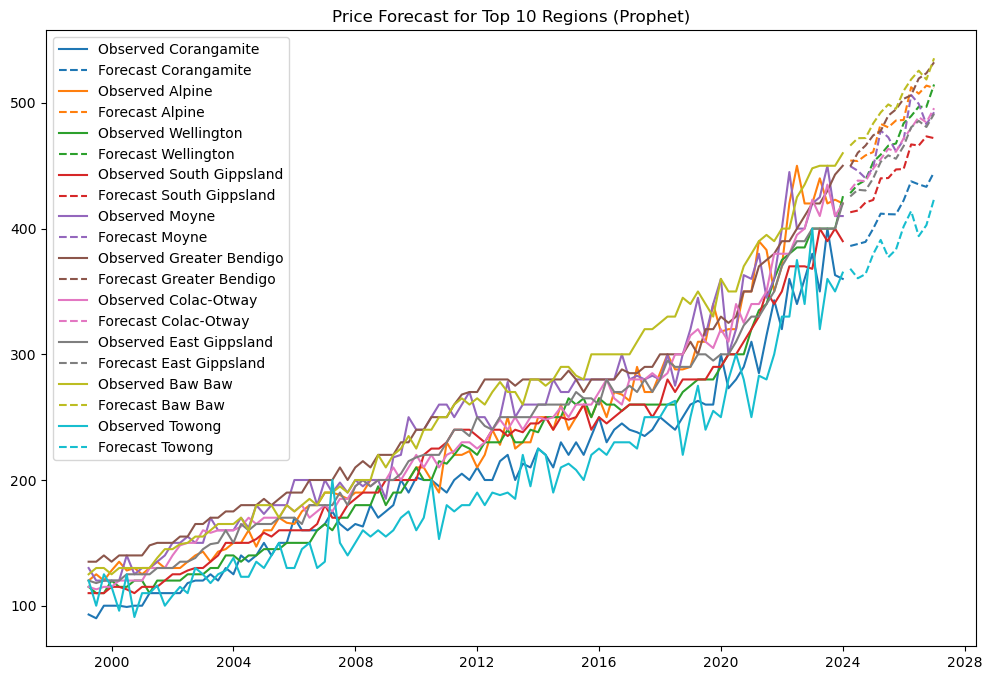

In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

df = pd.read_csv('../data/curated/final_merged_data_sa2.csv')

import re
price_columns = [col for col in df.columns if re.match(r'\b[A-Za-z]{3}\s\d{4}\smedian\b', col)]

df_prices = df[['LGA'] + price_columns]

df_prices_unique = df_prices.groupby('LGA').first()

df_prices_unique.columns = pd.to_datetime([col.replace(' median', '') for col in df_prices_unique.columns], errors='coerce', format='%b %Y')

df_prices_t = df_prices_unique.T

df_prices_t.index = pd.period_range(start='1999Q2', periods=len(df_prices_t.index), freq='Q') 

regions = df_prices_t.columns  

forecast_horizon = 12

predictions = {}

for region in regions:
    print(f"Processing {region}...")
    
    ts = df_prices_t[region].dropna()
    
    prophet_df = pd.DataFrame({
        'ds': ts.index.to_timestamp(),  
        'y': ts.values
    })
    
    model = Prophet()
    model.fit(prophet_df)
    
    future = model.make_future_dataframe(periods=forecast_horizon, freq='Q')
    
    forecast = model.predict(future)
    
    predictions[region] = forecast[['ds', 'yhat']].set_index('ds')['yhat'][-forecast_horizon:]  
    
predictions_df = pd.DataFrame(predictions)

current_prices = df_prices_t.iloc[-1][regions]

future_prices = predictions_df.iloc[-1]

price_increase = (future_prices - current_prices) / current_prices * 100

top_regions = price_increase.nlargest(10)  
print("The regions with the highest projected growth over the next three years:")
print(top_regions)

plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', len(top_regions)) 

for i, region in enumerate(top_regions.index):
    plt.plot(df_prices_t.index.to_timestamp(), df_prices_t[region], label=f"Observed {region}", color=colors(i))
    
    plt.plot(predictions_df.index, predictions_df[region], label=f"Forecast {region}", linestyle='--', color=colors(i))

plt.title("Price Forecast for Top 10 Regions (Prophet)")
plt.legend()
# Save the plot using the save_plot function
save_plot(plt.gcf(), 'price_forecast_top10_Prophet.png', output_dir='../plots')

plt.show()



price_increase_df = pd.DataFrame({
    'LGA': price_increase.index,
    'Future Price Increase (%)': price_increase.values
})

price_increase_df.to_csv('../data/results/price_increase_forecast_prophet.csv', index=False)

